[Reference](https://medium.com/analytics-vidhya/implementing-adversarial-attacks-and-defenses-in-keras-tensorflow-2-0-cab6120c5715)

# Init

In [2]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

# Load data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Preprocessing

In [4]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


# create model

In [6]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                      

# Generating the Perturbations

In [8]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        # since we only need the sign of the gradient. We can use MSE as loss here.
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [12]:
image = x_train[0]
image_label = y_train[0]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1

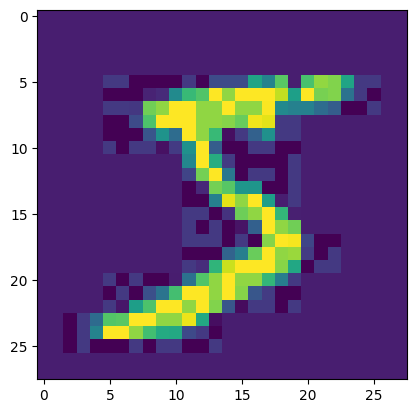

In [13]:
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

# Defend - include adversarial examples

In [15]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y